In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os
from matplotlib import pyplot as plt
# import seaborn as sns

rootFolder = os.getcwd()

In [3]:
# !nrnivmodl mod

In [4]:
from netpyne import sim
from netpyne import specs

cfg = specs.SimConfig()     

cfg.duration = 3000.0 ## Duration of the sim, in ms  
cfg.dt = 0.01
# ~ cfg.seeds = {'conn': 4321, 'stim': 1234, 'loc': 4321} 
cfg.hParams = {'celsius': 34, 'v_init': -65}  
cfg.verbose = False
cfg.createNEURONObj = True
cfg.createPyStruct = True
cfg.cvode_active = False
cfg.cvode_atol = 1e-6
cfg.cache_efficient = True
cfg.printRunTime = 0.5

cfg.includeParamsLabel = False
cfg.printPopAvgRates = True
cfg.checkErrors = False

allpops = ['PY_RS']
allcells = ['sPY']

cfg.recordCells = allcells  # which cells to record from
cfg.recordTraces = {'V_soma': {'sec':'soma_0', 'loc':0.5, 'var':'v'}}  ## Dict with traces to record
cfg.recordStim = True
cfg.recordTime = True
cfg.recordStep = 0.1            

cfg.simLabel = 'Pospischil2008_RS'
cfg.saveFolder = '.'
# cfg.filename =                	## Set file output name
cfg.savePickle = False         	## Save pkl file
cfg.saveJson = False           	## Save json file
cfg.saveDataInclude = ['simConfig', 'netParams', 'simData'] ## 
cfg.backupCfgFile = None 		##  
cfg.gatherOnlySimData = False	##  
cfg.saveCellSecs = False			##  
cfg.saveCellConns = False		##  

#------------------------------------------------------------------------------
# Analysis and plotting 
#------------------------------------------------------------------------------
cfg.analysis['plotTraces'] = {'include': allcells, 'saveFig': True, 'showFig': False, 'oneFigPer':'trace', 'overlay':False, 'figSize':(12, 8), 'fontSize':6}

#------------------------------------------------------------------------------
# Current inputs 
#------------------------------------------------------------------------------
cfg.addIClamp = 1

delaystim = 500
durationstim = 2000
step1_current = 1.0
        
cfg.IClamp5 = {'pop': 'sPY', 'sec': 'soma', 'loc': 0.5, 'start': delaystim, 'dur': durationstim, 'amp': step1_current}



In [5]:
netParams = specs.NetParams()   # object of class NetParams to store the network parameters

#------------------------------------------------------------------------------
# Cell parameters
#------------------------------------------------------------------------------
for cellName in allcells:
    cellRule = netParams.importCellParams(label=cellName + '_rule', somaAtOrigin=False,
        conds={'cellType': cellName, 'cellModel': 'HH_full'},
        fileName='cellwrapper_Pospischil2008.py',
        cellName='loadCellNotebook',
        cellArgs={'template': cellName},
        cellInstance = True)

    # observation:
    # - when import template cells the label of 'soma' is 'soma_0'.
    print(netParams.cellParams[cellName + '_rule']['secs']['soma_0'])

#------------------------------------------------------------------------------
# Population parameters
#------------------------------------------------------------------------------

# for ith-pop create pop with ith-cell of allcells 
for cell in allcells:
    netParams.popParams[cell] = {
        'cellType': cell,
        'cellModel': 'HH_full',
        'numCells': 1
    }

#------------------------------------------------------------------------------
# Current inputs (IClamp)
#------------------------------------------------------------------------------
if cfg.addIClamp:
     for key in [k for k in dir(cfg) if k.startswith('IClamp')]:
        params = getattr(cfg, key, None)
        [pop,sec,loc,start,dur,amp] = [params[s] for s in ['pop','sec','loc','start','dur','amp']]

        #cfg.analysis['plotTraces']['include'].append((pop,0))  # record that pop
        # add stim source
        netParams.stimSourceParams[key] = {'type': 'IClamp', 'delay': start, 'dur': dur, 'amp': amp}
        # connect stim source to target
        netParams.stimTargetParams[key+'_'+pop] =  {
            'source': key, 
            'conds': {'pop': pop},
            'sec': f'{sec}_0', # target 'soma_0'
            'loc': loc}

 
 << defining template for one-compartment sPY cell >> 
 
Loading cell sPY
 
<< sPY: passive, INa, IK, IM inserted >>
 
Creating a generic sPY cell from Pospischil2008 template
{geom: {L: 96.0, nseg: 1, diam: 96.0, Ra: 100.0, cm: 1.0}, topol: {}, mechs: {hh2: {gnabar: 0.05, gkbar: 0.005, vtraub: -55.0}, im: {gkbar: 7e-05}, pas: {g: 0.0001, e: -70.0}}, ions: {k: {e: -100.0, i: 54.4, o: 2.5}, na: {e: 50.0, i: 10.0, o: 140.0}}}


In [6]:
for pop in netParams.popParams.keys():
    print(pop, end=' ')

sPY 


Start time:  2023-03-24 13:14:25.558365

Creating network of 1 cell populations on 1 hosts...
  Number of cells on node 0: 1 
  Done; cell creation time = 0.00 s.
Making connections...
  Number of connections on node 0: 0 
  Done; cell connection time = 0.00 s.
Adding stims...
  Number of stims on node 0: 1 
  Done; cell stims creation time = 0.00 s.
Recording 2 traces of 2 types on node 0
0.0s

Running simulation using NEURON for 3000.0 ms...
0.5s
1.0s
1.5s
2.0s
2.5s
3.0s
  Done; run time = 0.43 s; real-time ratio: 7.00.

Gathering data...
  Done; gather time = 0.00 s.

Analyzing...
  Cells: 1
  Connections: 0 (0.00 per cell)
  Spikes: 49 (16.33 Hz)
  Simulated time: 3.0 s; 1 workers
  Run time: 0.43 s
   sPY : 16.333 Hz
Plotting recorded cell traces ... trace
  Done; plotting time = 0.10 s

Total time = 0.53 s


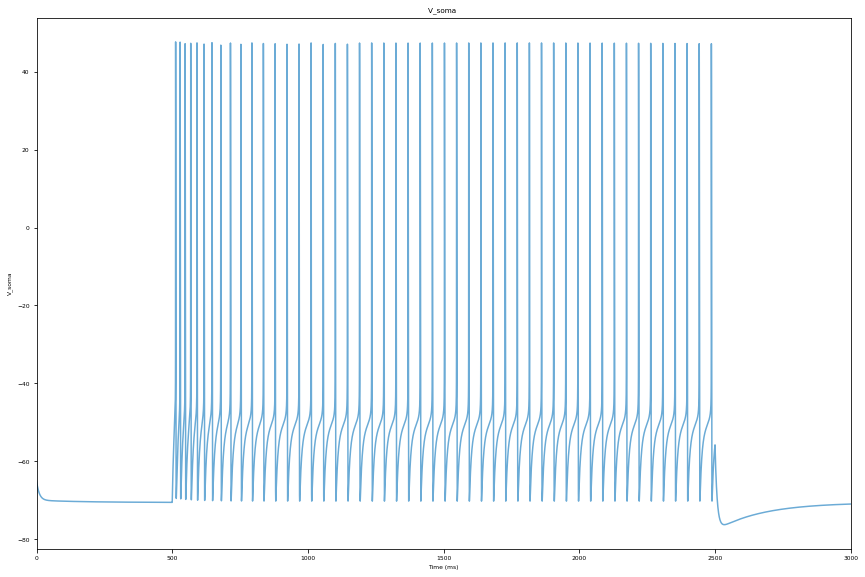

In [7]:
sim.createSimulateAnalyze(netParams, cfg)

Plotting recorded cell traces ... trace


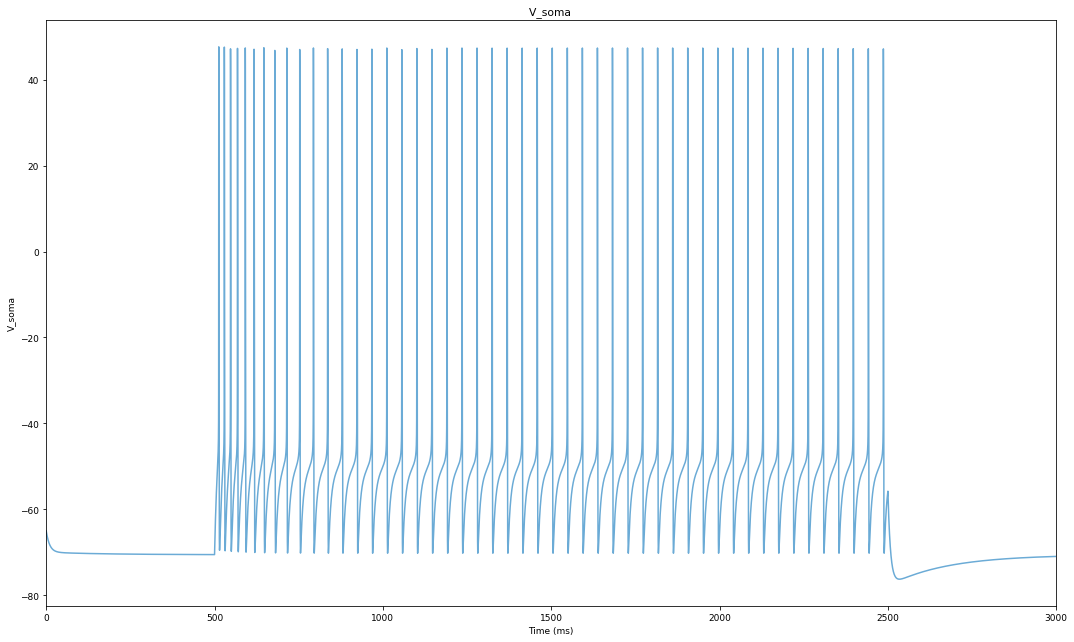

In [8]:
sim.analysis.plotTraces(include=cfg.recordCells,
 overlay=False, oneFigPer='trace', figSize=(15, 9),
 fontSize=9, saveFig=True);